# PART 1

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(0)
random.seed(0)

class GridworldEnv:
    def __init__(self):
        # Create the grid world with required size and initial parameters
        self.grid_size = 5
        self.start_state = (4, 0)  # Starting state at the bottom-left corner the blue cell 
        self.terminal_states = [(0, 0), (0, 4)]  # Terminal states at top-left and top-right corners
        self.wall_states = [(2, 0), (2, 1), (2, 3), (2, 4)]  # Wall states in the third row 
        self.state = self.start_state  # Initialize the current state begin with the start state
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']  # Define possible actions
        self.action_effects = {
            'UP': (-1, 0),    # Action effects in terms of grid movement
            'DOWN': (1, 0),
            'LEFT': (0, -1),
            'RIGHT': (0, 1)
        }
        self.action_text = ['\u2191', '\u2193', '\u2190', '\u2192']  # Unicode arrows for actions

    def reset(self):
        # Reset the environment to the start state
        self.state = self.start_state
        return self.state

    def step(self, action):
        # Perform an action and return the next state, reward, and done status
        if self.state in self.terminal_states:
            return self.state, 0, True  # No movement if in terminal state, reward is 0, done is True
        
        move = self.action_effects[action]
        next_state = (self.state[0] + move[0], self.state[1] + move[1])

        # Check for boundaries and walls
        if next_state[0] < 0 or next_state[0] >= self.grid_size or next_state[1] < 0 or next_state[1] >= self.grid_size:
            next_state = self.state  # Stay in the same state if move is out of grid
            reward = -1  # Penalize for hitting boundary
        elif next_state in self.wall_states:
            next_state = self.start_state  # Go back to start state if hit wall
            reward = -20  # Penalize heavily for hitting wall
        else:
            reward = -1  # Small penalty for each move
        
        done = next_state in self.terminal_states  # Check if the new state is a terminal state
        self.state = next_state  # Update current state
        
        return next_state, reward, done

    def get_path(self, Q):
        # Get the path from start state to a terminal state using the policy derived from Q-values
        self.reset()
        state = self.start_state
        path = [state]
        while state not in self.terminal_states:
            action = np.argmax(Q[state])  # Choose the best action from Q-values
            next_state, _, done = self.step(self.actions[action])
            if next_state == state:
                break  # Break if no movement
            path.append(next_state)
            state = next_state
            if done:
                break
        return path







In [2]:

def print_policy(Q, env):
    # Print the policy based on the Q-values
    policy_visual = [['' for _ in range(env.grid_size)] for _ in range(env.grid_size)]
    for state, actions in Q.items():
        best_actions = np.flatnonzero(actions == np.max(actions))  # Find actions with maximum Q-value
        policy_visual[state[0]][state[1]] = ''.join([env.action_text[action] for action in best_actions])  # Visualize all best actions
    return policy_visual

def plot_path(path, env, title):
    # Plot the path taken by the agent
    grid = np.zeros((env.grid_size, env.grid_size))  # Initialize grid for plotting
    for (x, y) in env.wall_states:
        grid[x, y] = -20  # Mark wall states with -20
    for (x, y) in env.terminal_states:
        grid[x, y] = 100  # Mark terminal states with 100
    grid[env.start_state[0], env.start_state[1]] = 50  # Mark start state with 50

    plt.figure(figsize=(8, 6))
    sns.heatmap(grid, annot=False, cmap='coolwarm', cbar=False)  # Plot heatmap of the grid

    # Plot the path with arrows
    for i in range(1, len(path)):
        plt.plot([path[i-1][1] + 0.5, path[i][1] + 0.5], [path[i-1][0] + 0.5, path[i][0] + 0.5], 'k-')
    plt.scatter([p[1] + 0.5 for p in path], [p[0] + 0.5 for p in path], color='black')
    
    plt.title(title)
    plt.show()

def plot_rewards(sarsa_rewards, q_learning_rewards):
    # Plot the rewards obtained over episodes
    plt.figure(figsize=(10, 6))
    plt.plot(sarsa_rewards, label='Sarsa')
    plt.plot(q_learning_rewards, label='Q-learning')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

In [3]:
def epsilon_greedy_policy(state, Q, epsilon, n_actions):
    # Epsilon-greedy policy for action selection
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, n_actions - 1)  # Choose random action with probability epsilon
    else:
        return np.argmax(Q[state])  # Choose best action with probability 1-epsilon

def sarsa(env, num_episodes, alpha, gamma, epsilon):
    # SARSA algorithm for training
    Q = {}
    for x in range(env.grid_size):
        for y in range(env.grid_size):
            Q[(x, y)] = np.zeros(len(env.actions))  # Initialize Q-values for all state-action pairs
    
    rewards = []  # Store rewards for each episode
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset environment to start state
        action = epsilon_greedy_policy(state, Q, epsilon, len(env.actions))  # Choose initial action
        total_reward = 0
        
        while True:
            next_state, reward, done = env.step(env.actions[action])  # Take action and observe reward and next state
            next_action = epsilon_greedy_policy(next_state, Q, epsilon, len(env.actions))  # Choose next action
            
            td_target = reward + gamma * Q[next_state][next_action]  # Compute TD target
            td_error = td_target - Q[state][action]  # Compute TD error
            Q[state][action] += alpha * td_error  # Update Q-value
            
            state, action = next_state, next_action  # Update state and action
            total_reward += reward  # Accumulate reward
            
            if done:
                break
        
        rewards.append(total_reward)  # Store total reward for the episode
    
    return Q, rewards

In [4]:
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    # Q-learning algorithm for training
    Q = {}
    for x in range(env.grid_size):
        for y in range(env.grid_size):
            Q[(x, y)] = np.zeros(len(env.actions))  # Initialize Q-values for all state-action pairs
    
    rewards = []  # Store rewards for each episode
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset environment to start state
        total_reward = 0
        
        while True:
            action = epsilon_greedy_policy(state, Q, epsilon, len(env.actions))  # Choose action using epsilon-greedy policy
            next_state, reward, done = env.step(env.actions[action])  # Take action and observe reward and next state
            
            best_next_action = np.argmax(Q[next_state])  # Choose best next action
            td_target = reward + gamma * Q[next_state][best_next_action]  # Compute TD target
            td_error = td_target - Q[state][action]  # Compute TD error
            Q[state][action] += alpha * td_error  # Update Q-value
            
            state = next_state  # Update state
            total_reward += reward  # Accumulate reward
            
            if done:
                break
        
        rewards.append(total_reward)  # Store total reward for the episode
    
    return Q, rewards

In [5]:
def run_experiments(parameter_sets):
    # Run experiments with different parameter sets
    env = GridworldEnv()
    num_episodes = 10000
    

    for i, params in enumerate(parameter_sets):
        alpha = params["alpha"]
        gamma = params["gamma"]
        epsilon = params["epsilon"]

        Q_sarsa, sarsa_rewards = sarsa(env, num_episodes, alpha, gamma, epsilon)
        Q_q_learning, q_learning_rewards = q_learning(env, num_episodes, alpha, gamma, epsilon)
        
        path_sarsa = env.get_path(Q_sarsa)
        path_q_learning = env.get_path(Q_q_learning)
        
        print(f"Experiment {i+1} - Parameters: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")
        print("SARSA Path:", path_sarsa)
        print("Q-learning Path:", path_q_learning)
        
        plot_path(path_sarsa, env, f"Trajectory using SARSA (alpha={alpha}, gamma={gamma}, epsilon={epsilon})")
        plot_path(path_q_learning, env, f"Trajectory using Q-learning (alpha={alpha}, gamma={gamma}, epsilon={epsilon})")
        
        plot_rewards(sarsa_rewards, q_learning_rewards)
        
        policy_sarsa = print_policy(Q_sarsa, env)
        policy_q_learning = print_policy(Q_q_learning, env)
        
        print("SARSA Policy:")
        print(np.array(policy_sarsa))
        print("Q-learning Policy:")
        print(np.array(policy_q_learning))
        

In [6]:

parameter_set1 = [
        {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.01},
        {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.01},
        {"alpha": 0.2, "gamma": 0.95, "epsilon": 0.01},
    ]

parameter_set2 = [
      
        # gamma = 0.99 small alpha and epsilon 

        {"alpha": 0.5, "gamma": 0.95, "epsilon": 0.2},
        {"alpha": 0.2, "gamma": 0.95, "epsilon": 0.01},
        {"alpha": 0.1, "gamma": 0.95, "epsilon": 0.1},
        {"alpha": 0.01, "gamma": 0.95, "epsilon": 0.01}

       
        # {"alpha": 0.01, "gamma": 0.95, "epsilon": 0.01}
    ]
parameter_set3 = [
      

        {"alpha": 0.5, "gamma": 0.99, "epsilon": 0.2},
        {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.01},
         {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1},
        {"alpha": 0.01, "gamma": 0.99, "epsilon": 0.01}
    ]

parameter_set4 = [
      

        {"alpha": 0.5, "gamma": 0.9, "epsilon": 0.01},
        {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.01},
         {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.1},
        {"alpha": 0.01, "gamma": 0.9, "epsilon": 0.01}
    ]


## Run with different gamma values

Experiment 1 - Parameters: alpha=0.2, gamma=0.99, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


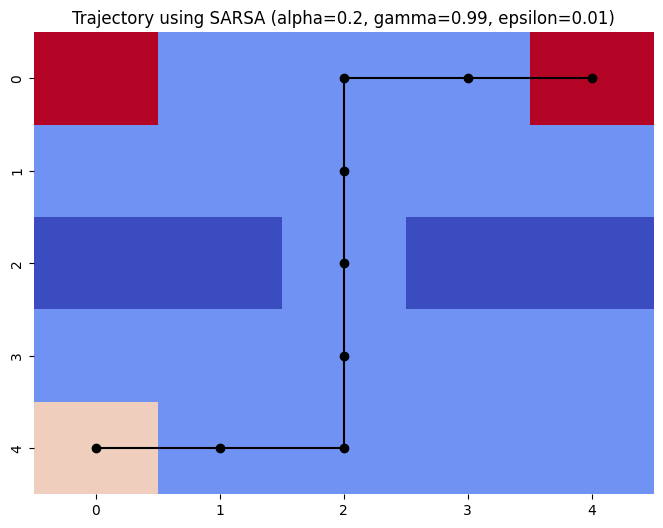

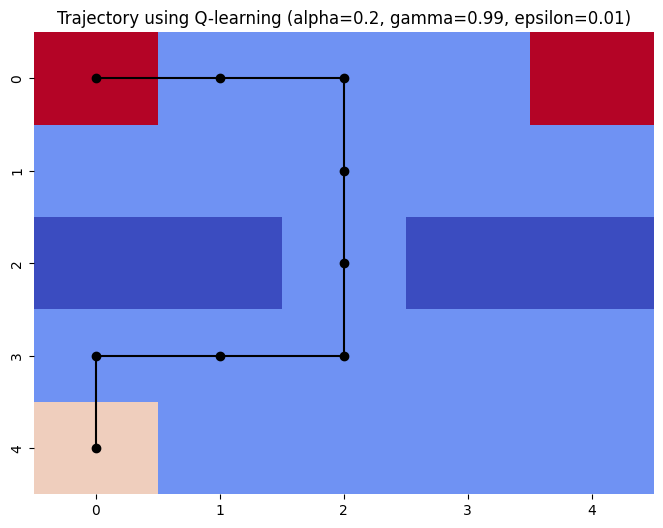

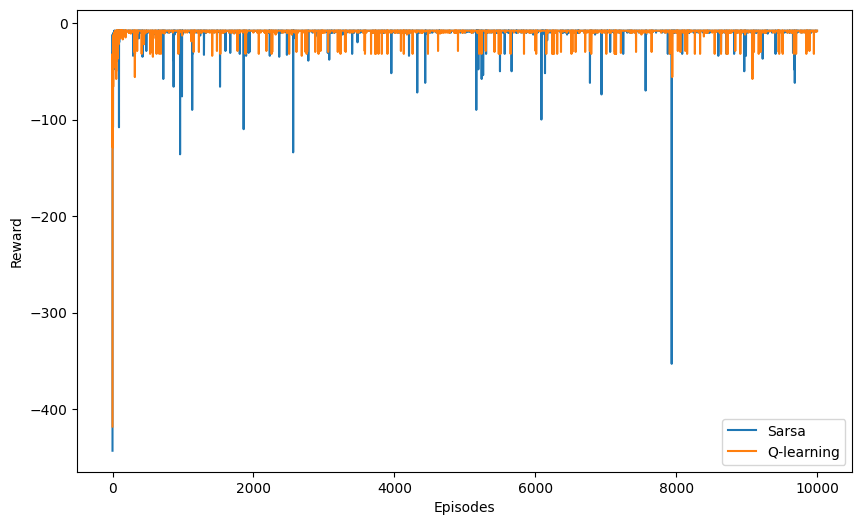

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '←' '↑' '→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '↓' '↑' '←' '←']
 ['→' '→' '↑' '↓' '→']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '→']
 ['↑→' '↑→' '↑' '↑' '→']]
Experiment 2 - Parameters: alpha=0.2, gamma=0.9, epsilon=0.01
SARSA Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


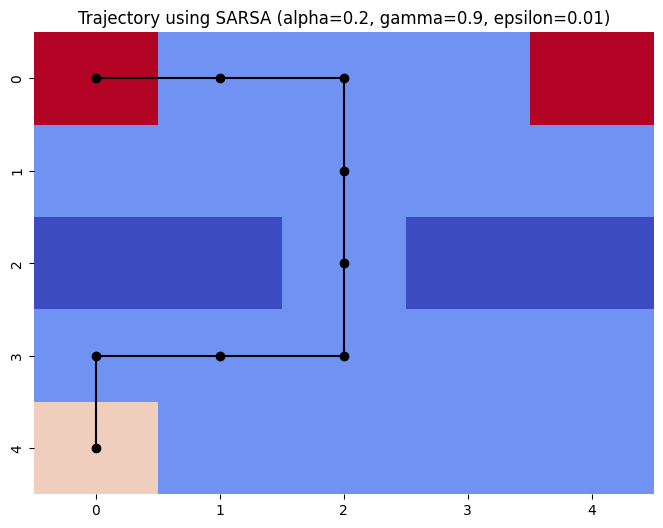

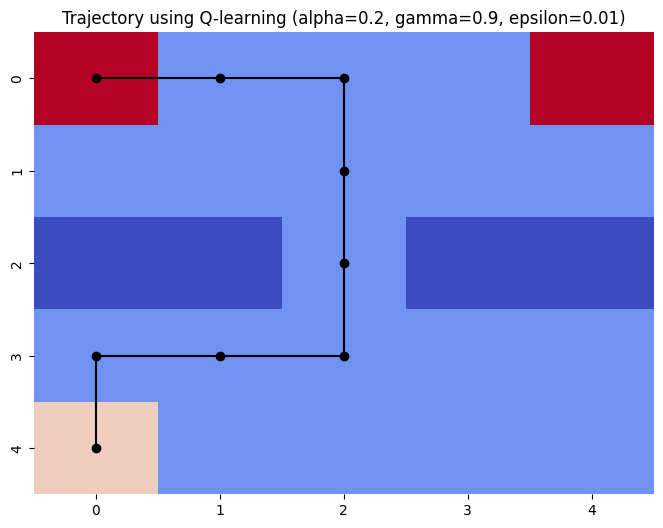

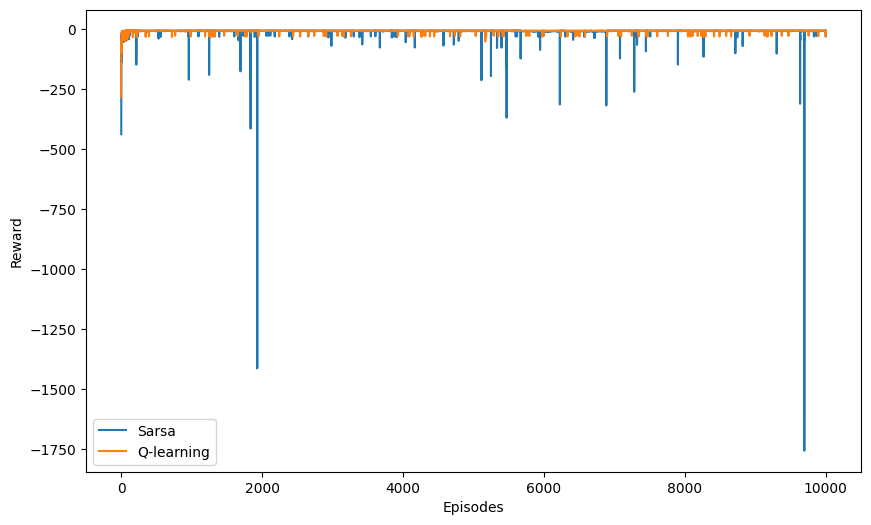

SARSA Policy:
[['↑↓←→' '←' '←' '→' '↑↓←→']
 ['↑' '←' '↑' '→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '→']
 ['↑' '↑' '↑' '↓' '↑']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '↓']
 ['↑→' '↑→' '↑' '↑' '↑']]
Experiment 3 - Parameters: alpha=0.2, gamma=0.95, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


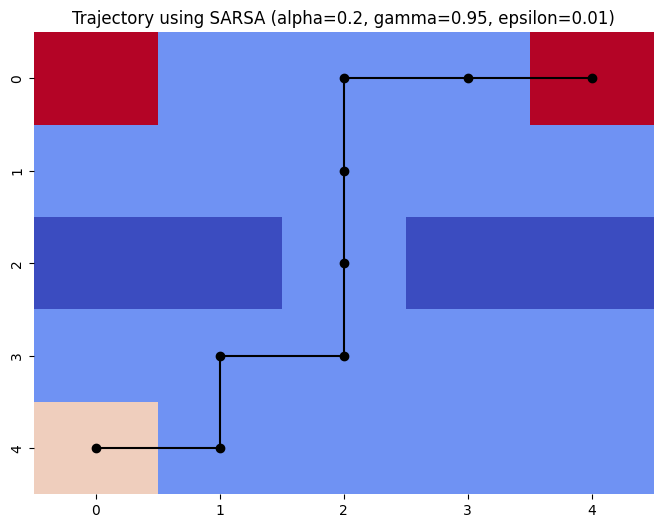

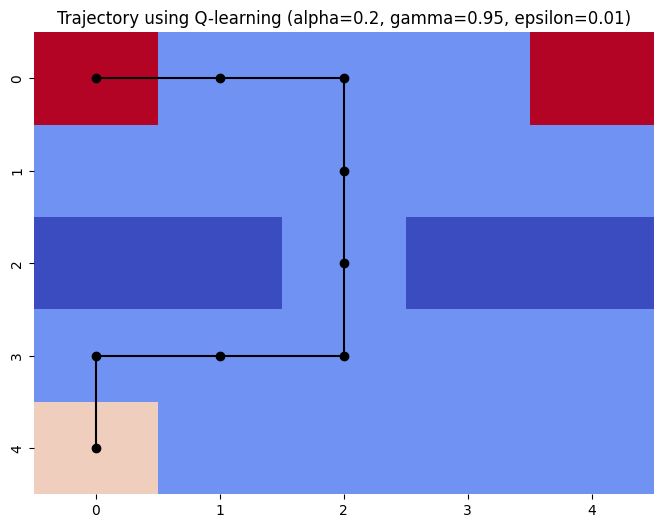

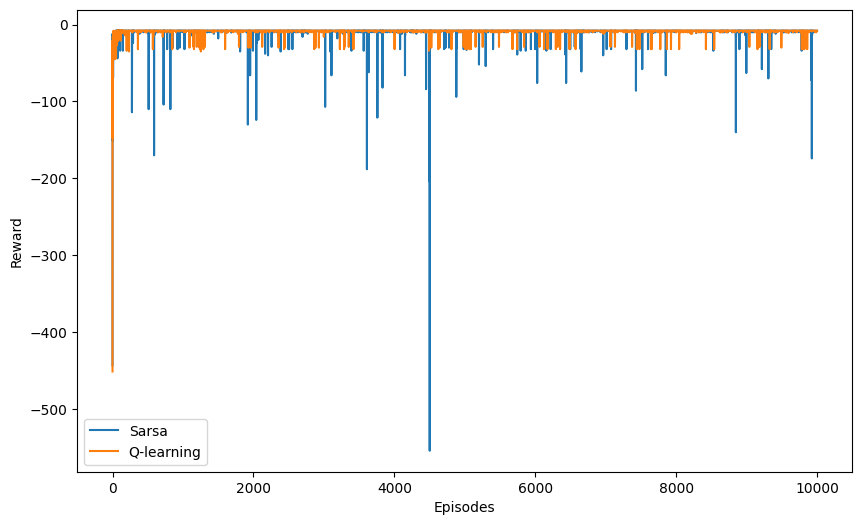

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '→' '↑' '←' '↓']
 ['→' '↑' '↑' '←' '→']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '↓']
 ['↑→' '↑→' '↑' '→' '↑']]


In [7]:
run_experiments(parameter_set1)

## Run with Gamma = 0.95 

Experiment 1 - Parameters: alpha=0.5, gamma=0.95, epsilon=0.2
SARSA Path: [(4, 0), (4, 1), (3, 1), (3, 2), (2, 2), (1, 2), (1, 3), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


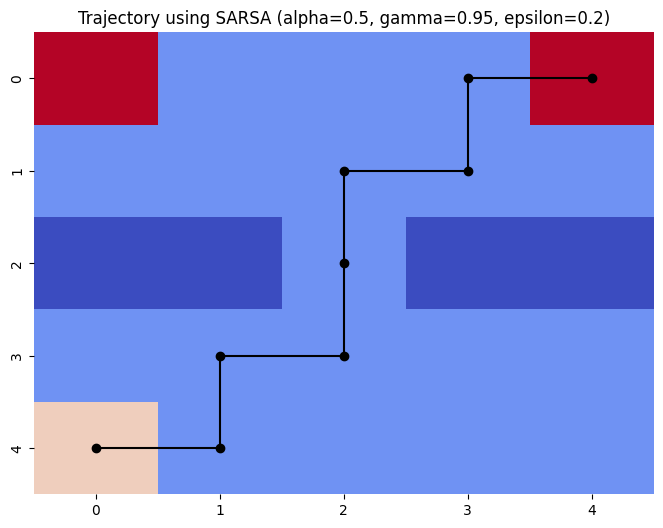

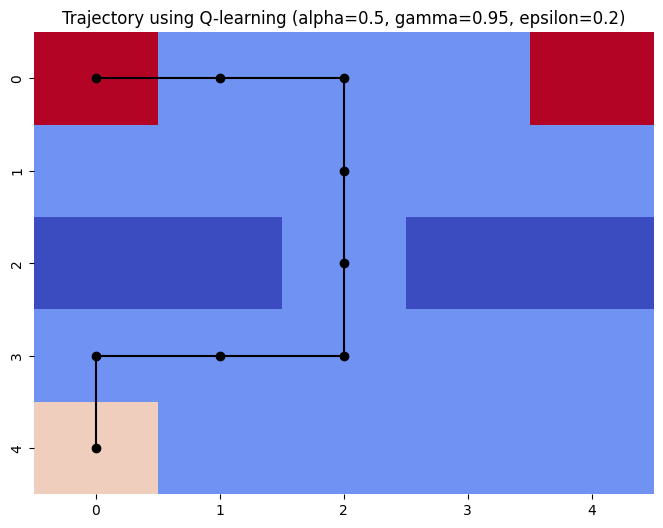

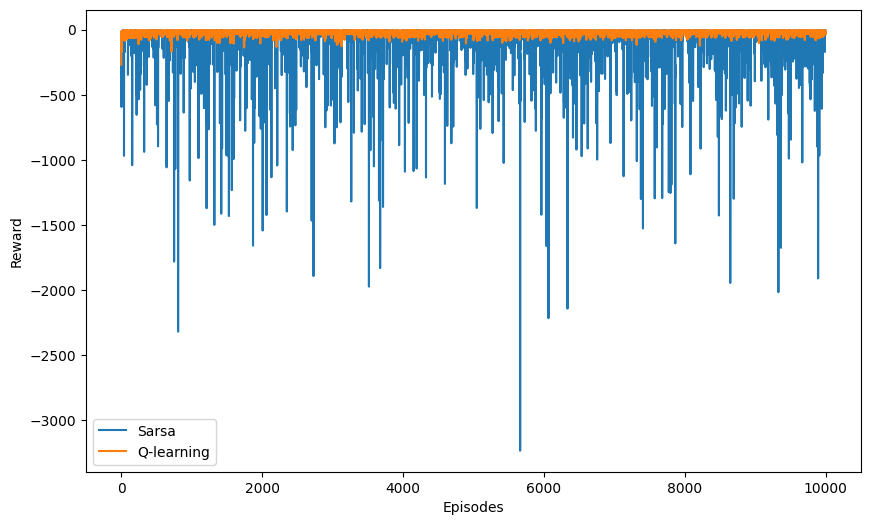

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '↑' '→' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '→' '↑' '←' '↓']
 ['→' '↑' '←' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '←']
 ['↑→' '↑→' '↑' '↑←' '→']]
Experiment 2 - Parameters: alpha=0.2, gamma=0.95, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


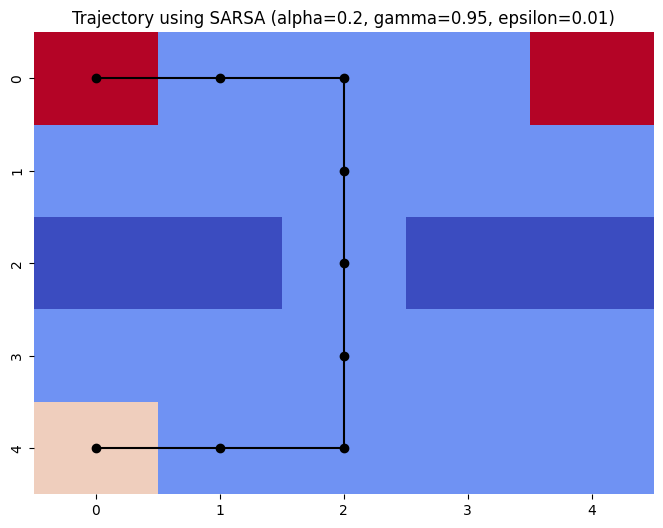

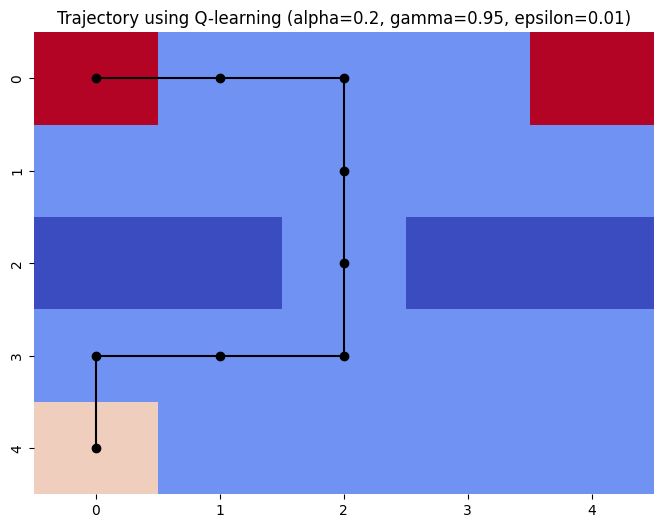

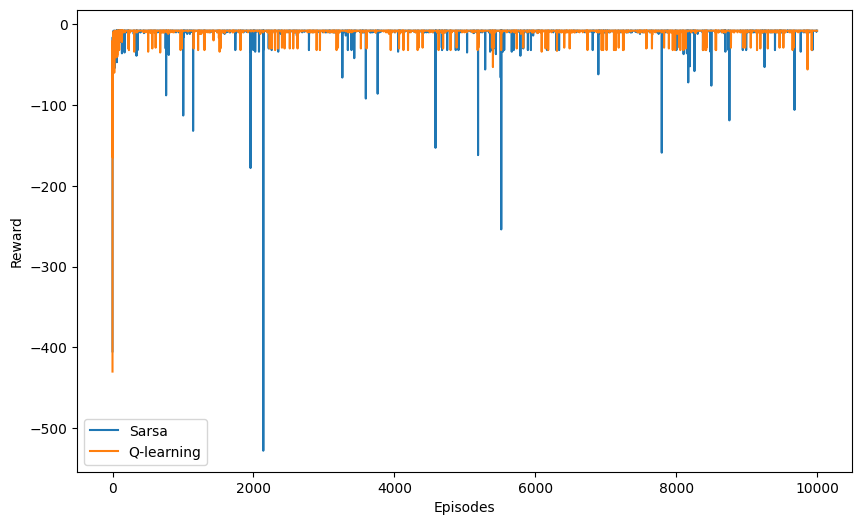

SARSA Policy:
[['↑↓←→' '←' '←' '→' '↑↓←→']
 ['↑' '←' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '→' '↑' '←' '↓']
 ['→' '→' '↑' '↑' '↑']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '→']
 ['↑→' '↑→' '↑' '↓' '↓→']]
Experiment 3 - Parameters: alpha=0.1, gamma=0.95, epsilon=0.1
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


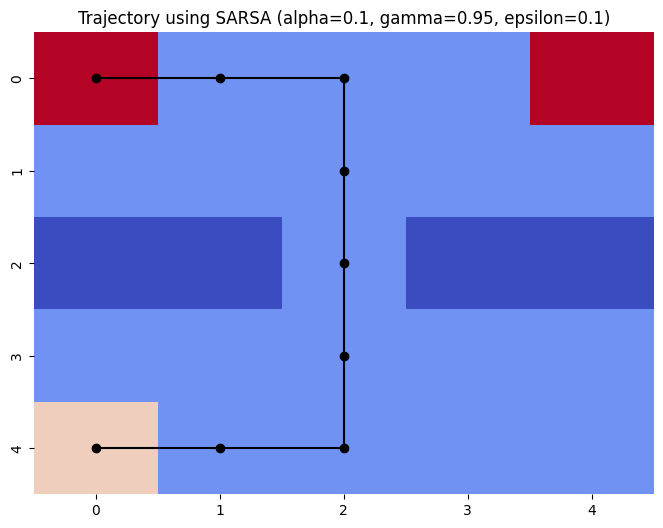

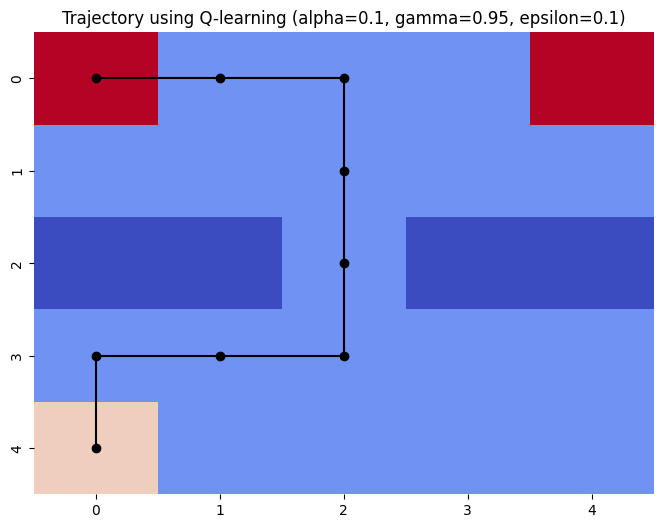

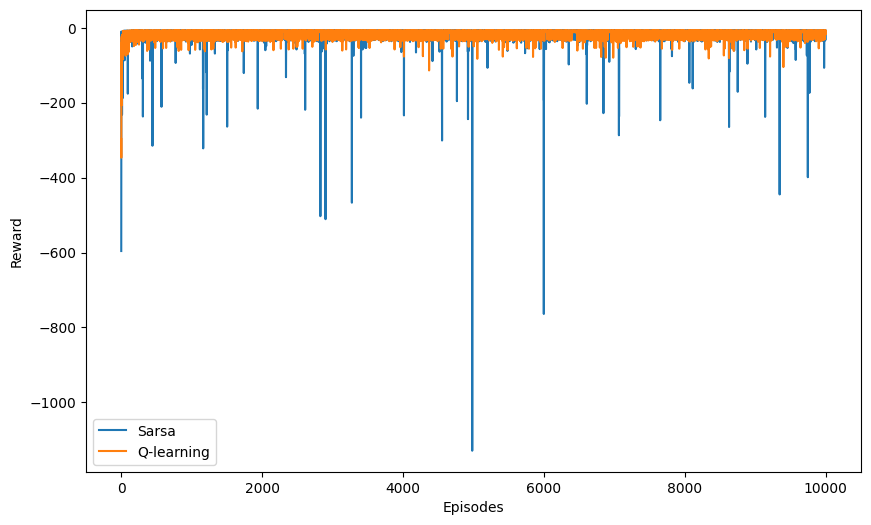

SARSA Policy:
[['↑↓←→' '←' '←' '→' '↑↓←→']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '→' '↑' '←' '←']
 ['→' '→' '↑' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '←']
 ['↑→' '↑→' '↑' '↓' '←']]
Experiment 4 - Parameters: alpha=0.01, gamma=0.95, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (4, 1), (3, 1), (3, 2), (2, 2), (1, 2), (1, 3), (1, 4), (0, 4)]


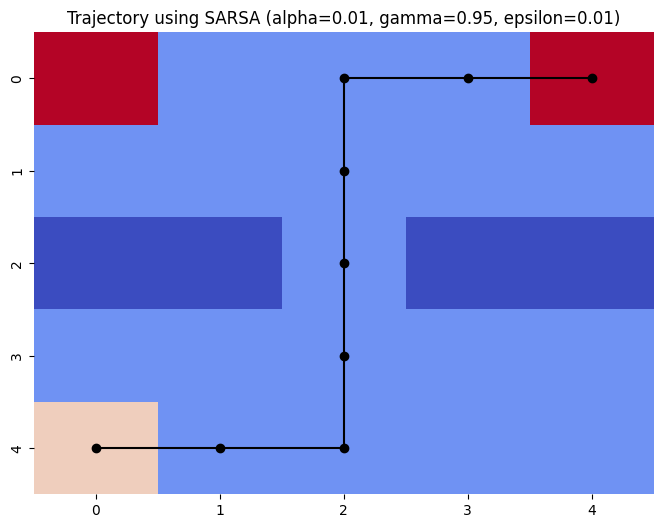

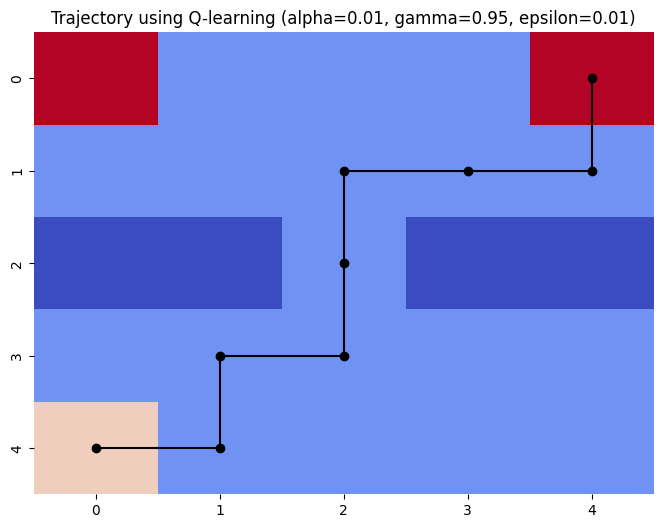

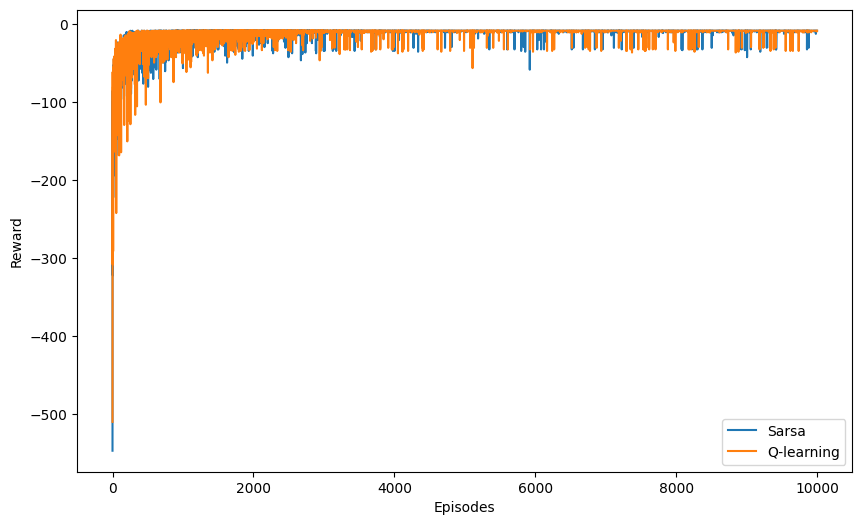

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '↓']
 ['→' '→' '↑' '↓' '↑']]
Q-learning Policy:
[['↑↓←→' '←' '←' '→' '↑↓←→']
 ['↑' '↑' '→' '→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '→' '←']
 ['→' '↑' '↑' '→' '↓']]


In [15]:
run_experiments(parameter_set2)

## Run with Gamma = 0.99

Experiment 1 - Parameters: alpha=0.5, gamma=0.99, epsilon=0.2
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


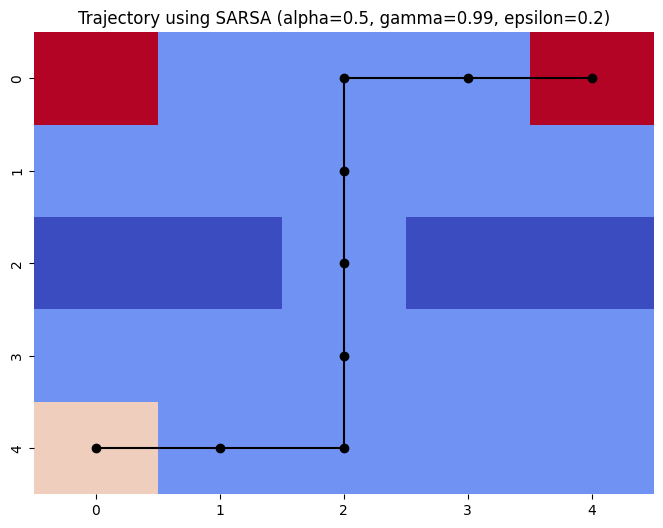

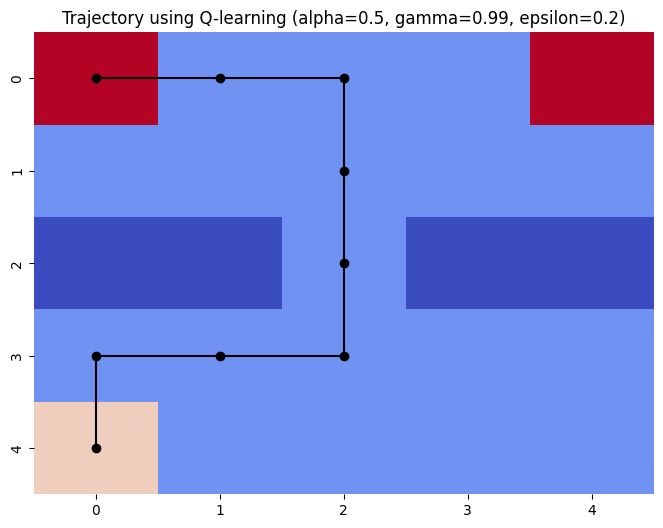

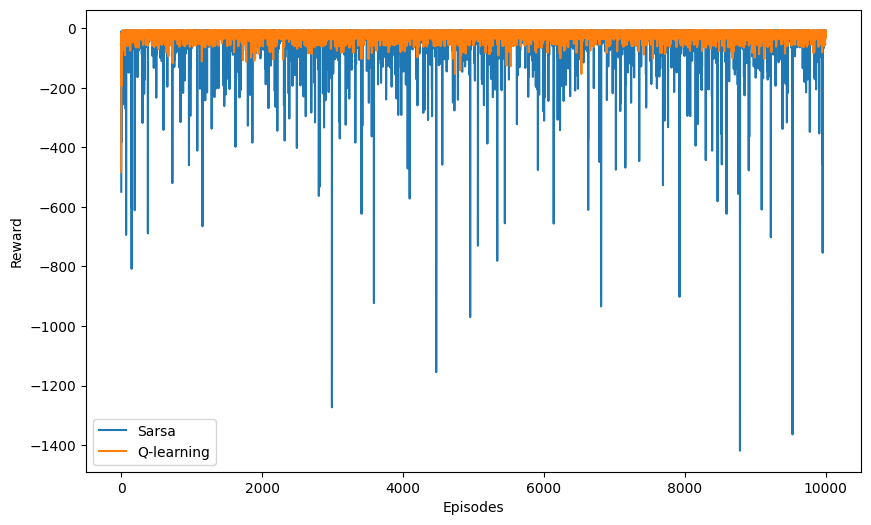

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '←' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '→' '↑' '↓' '←']
 ['→' '→' '↑' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '←']
 ['↑→' '↑→' '↑' '←' '←']]
Experiment 2 - Parameters: alpha=0.2, gamma=0.99, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


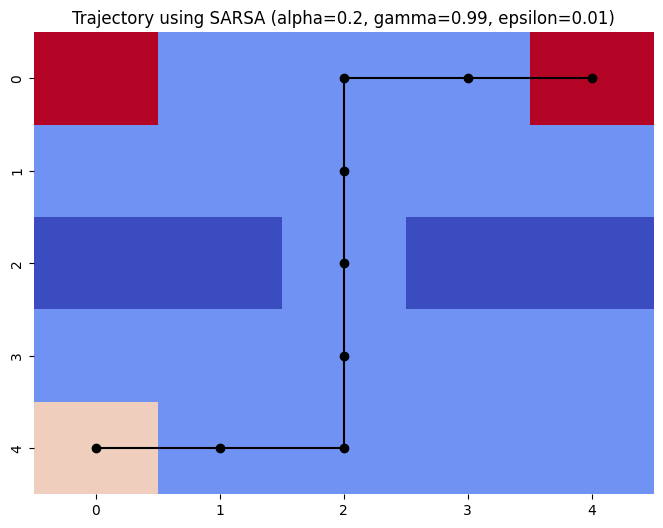

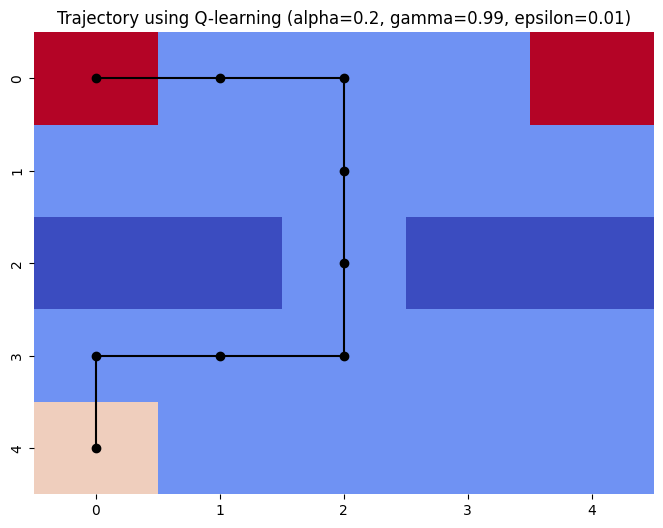

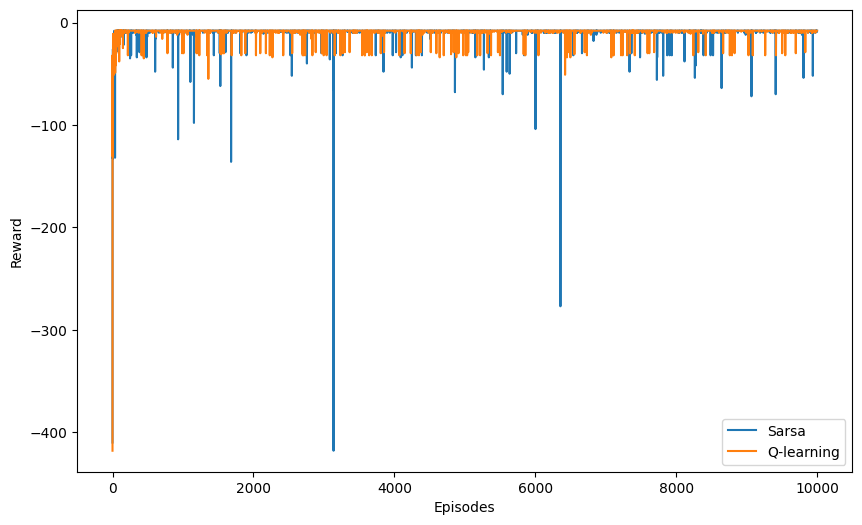

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '←' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '→' '↑' '←' '↓']
 ['→' '→' '↑' '↑' '↑']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '↓']
 ['↑→' '↑→' '↑' '↑' '←']]
Experiment 3 - Parameters: alpha=0.1, gamma=0.99, epsilon=0.1
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


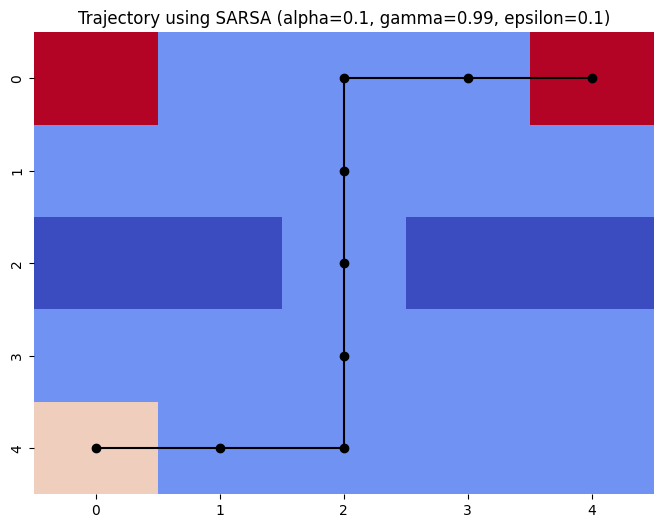

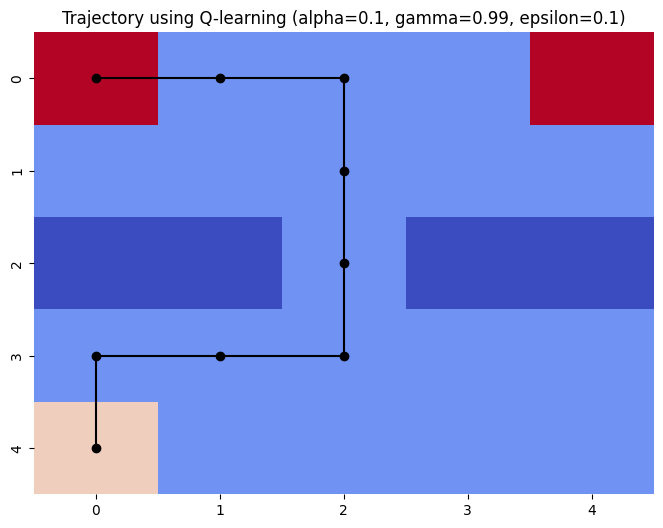

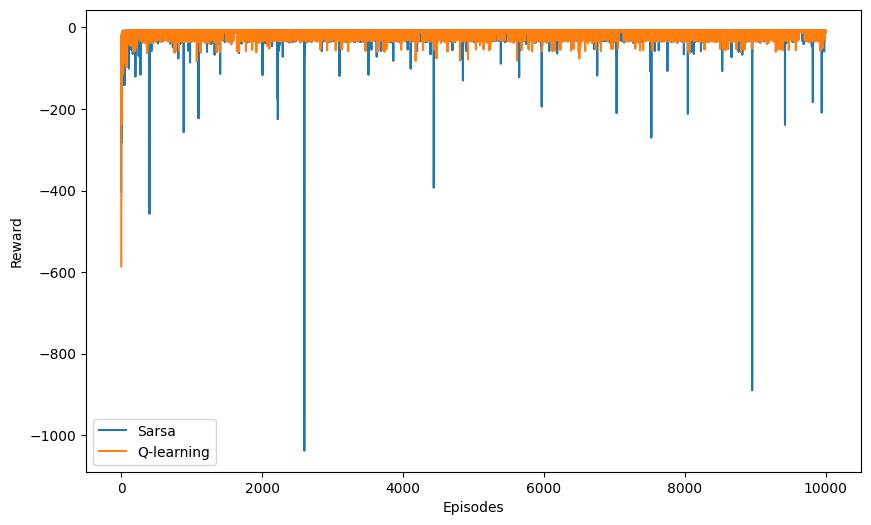

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '↑' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '←']
 ['→' '→' '↑' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '→']
 ['↑→' '↑→' '↑' '↑' '→']]
Experiment 4 - Parameters: alpha=0.01, gamma=0.99, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Q-learning Path: [(4, 0), (4, 1), (3, 1), (3, 2), (2, 2), (1, 2), (1, 3), (0, 3), (0, 4)]


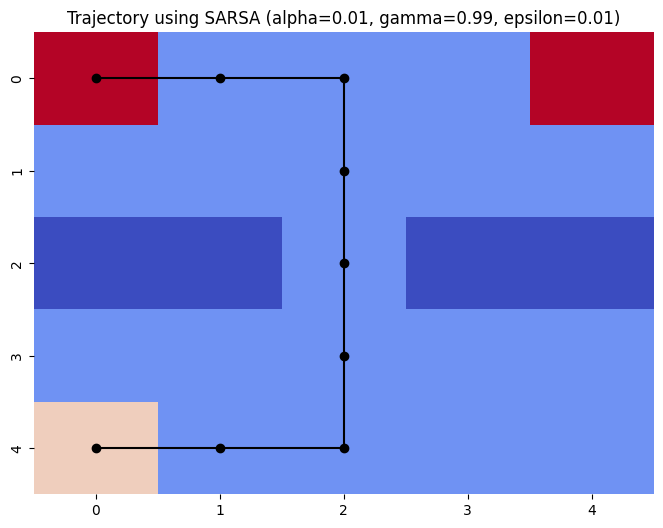

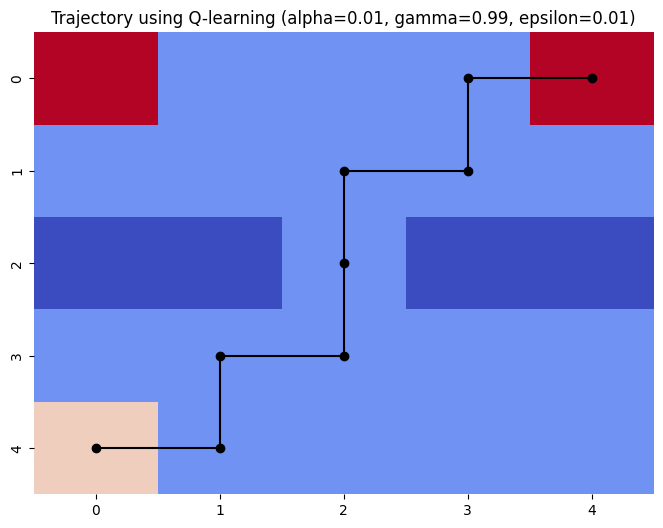

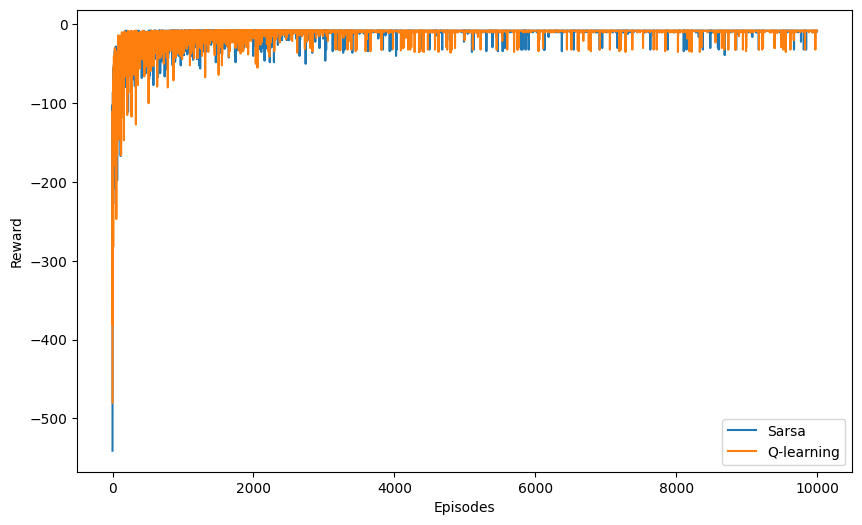

SARSA Policy:
[['↑↓←→' '←' '←' '→' '↑↓←→']
 ['↑' '←' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '↓']
 ['→' '→' '↑' '←' '↓']]
Q-learning Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '↑' '→' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '→']
 ['→' '↑' '↑' '↓' '→']]


In [8]:
run_experiments(parameter_set3)

## Run with gamma = 0.9

Experiment 1 - Parameters: alpha=0.5, gamma=0.9, epsilon=0.01
SARSA Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


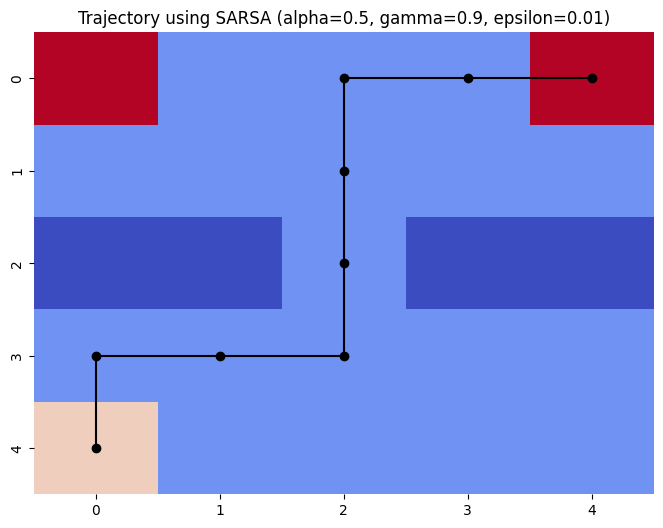

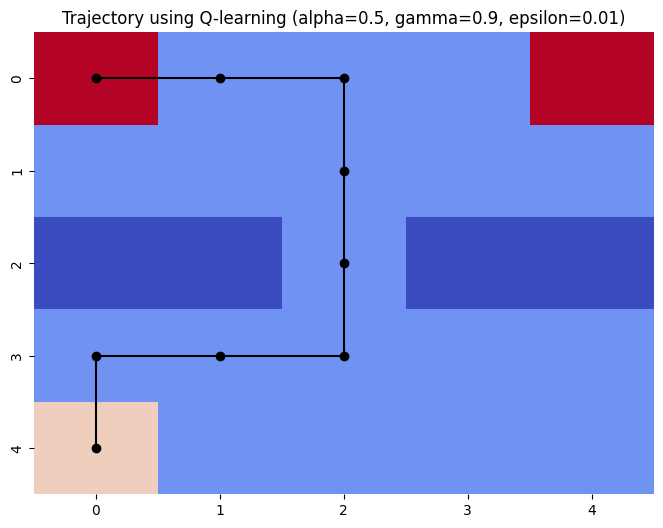

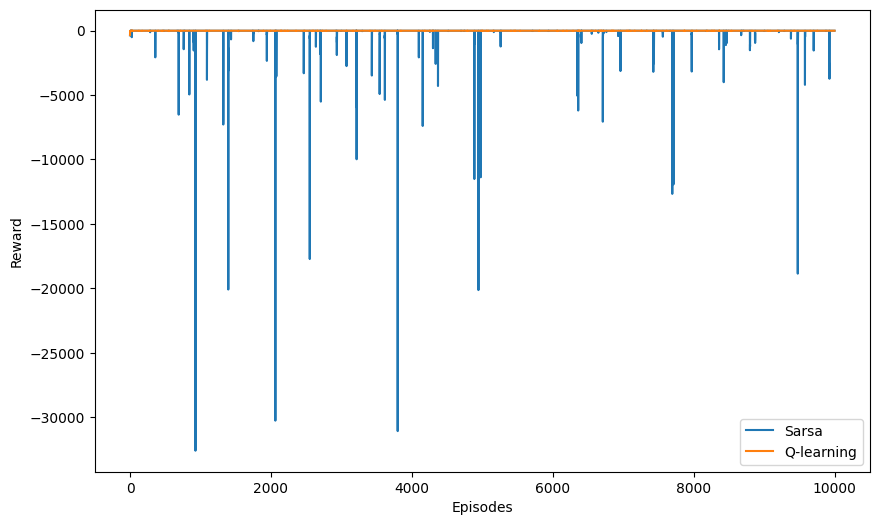

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '↑' '↑' '→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '→' '↓']
 ['↑' '←' '↑' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '←']
 ['↑→' '↑→' '↑' '↑' '↑']]
Experiment 2 - Parameters: alpha=0.2, gamma=0.9, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (1, 1), (1, 0), (0, 0)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


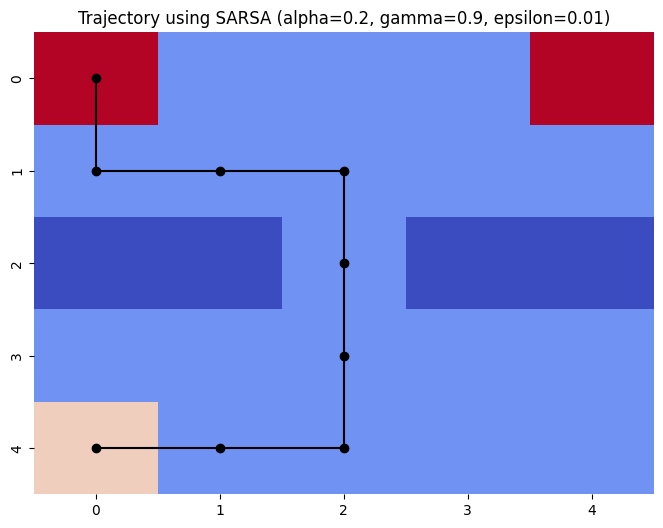

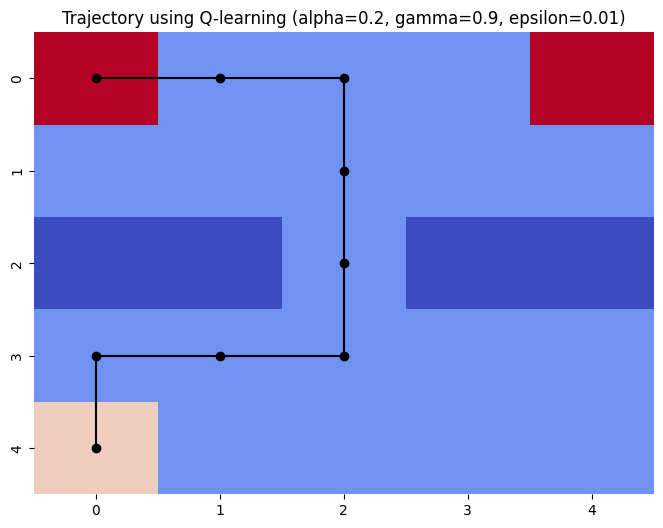

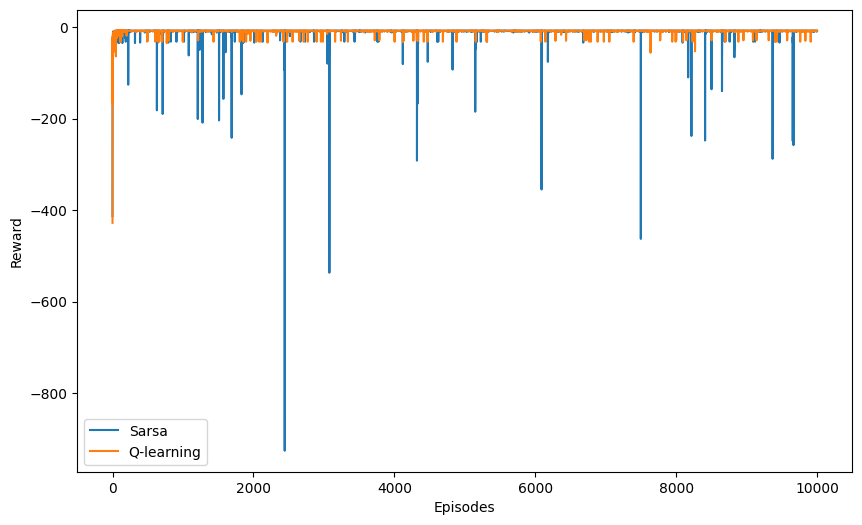

SARSA Policy:
[['↑↓←→' '←' '←' '→' '↑↓←→']
 ['↑' '←' '←' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '→' '↑' '←' '→']
 ['→' '→' '↑' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '↓']
 ['↑→' '↑→' '↑' '↓' '←']]
Experiment 3 - Parameters: alpha=0.1, gamma=0.9, epsilon=0.1
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (1, 3), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]


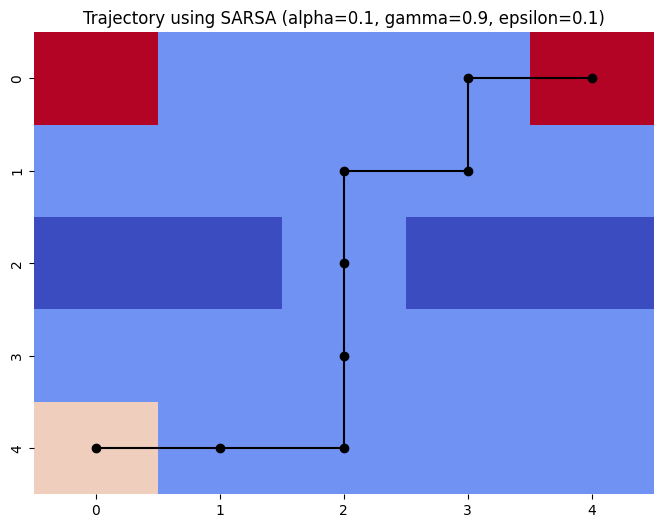

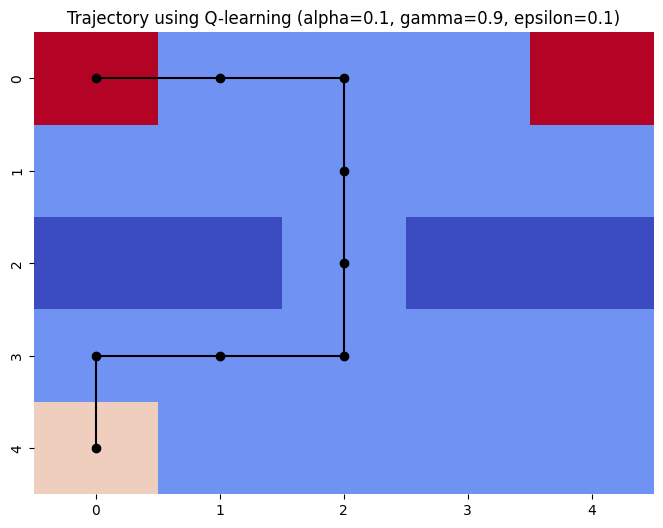

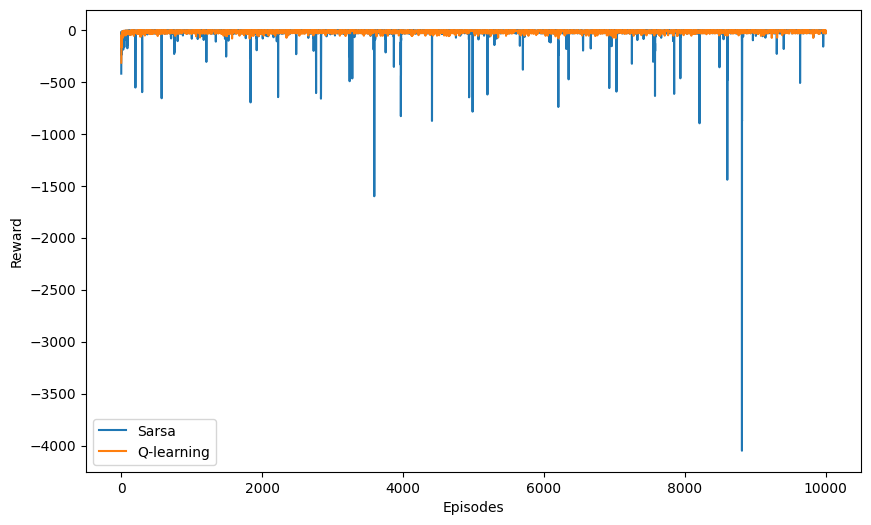

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '↑' '→' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['↓' '↓' '↑' '←' '↓']
 ['→' '→' '↑' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '←→' '→' '↑↓←→']
 ['↑' '↑←' '↑←→' '↑→' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '←' '→']
 ['↑→' '↑→' '↑' '↑' '↓']]
Experiment 4 - Parameters: alpha=0.01, gamma=0.9, epsilon=0.01
SARSA Path: [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
Q-learning Path: [(4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]


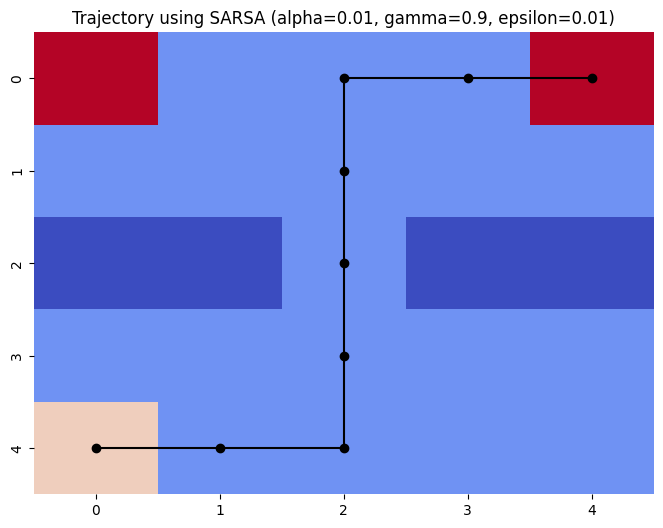

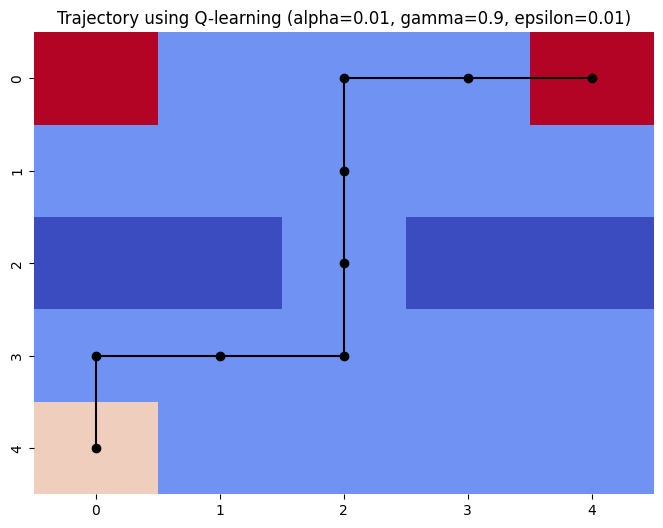

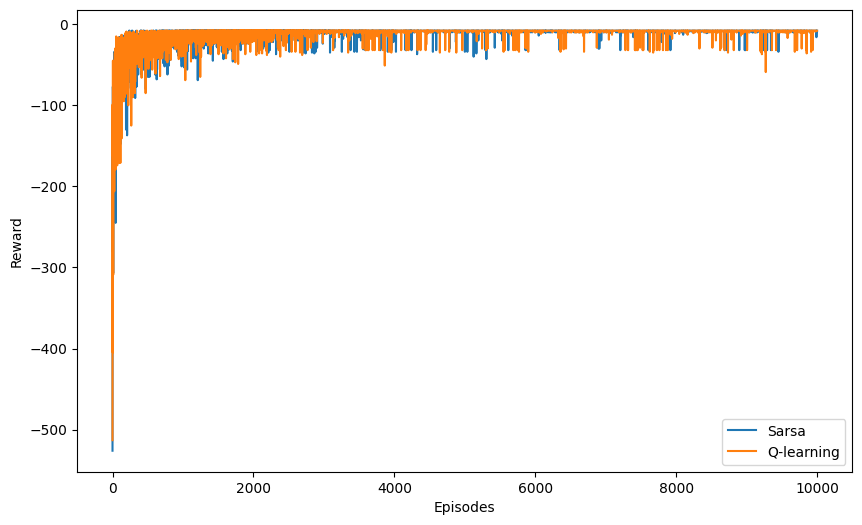

SARSA Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '←' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '↓' '↓']
 ['→' '→' '↑' '←' '←']]
Q-learning Policy:
[['↑↓←→' '←' '→' '→' '↑↓←→']
 ['↑' '←' '↑' '↑' '↑']
 ['↑↓←→' '↑↓←→' '↑' '↑↓←→' '↑↓←→']
 ['→' '→' '↑' '↓' '↓']
 ['↑' '↑' '↑' '←' '←']]


In [9]:
run_experiments(parameter_set4)

# Part 2

## Plot helper function

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot(array):
# Step 2: Use matplotlib to create a plot and display the array values within the squares
  fig, ax = plt.subplots()

  # Custom colors for specific squares
  special_colors = {
      (6, 0): 'black',
      (0, 6): 'black'
  }

  # Loop over data dimensions and create text annotations and colored squares.
  for (i, j), val in np.ndenumerate(array):
      # Default color is white
      color = 'white'
      if (i, j) in special_colors:
          color = special_colors[(i, j)]
      # Add a colored rectangle for all cells, default or special color
      ax.add_patch(patches.Rectangle((j-0.5, 6-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))
      ax.text(j, 6-i, f'{val}', ha='center', va='center', color='black')

  # Hide the x and y axes
  ax.set_xticks(np.arange(-0.5, 7, 1), minor=True)
  ax.set_yticks(np.arange(-0.5, 7, 1), minor=True)
  ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
  ax.tick_params(which="minor", size=0)

  ax.set_xticks([])
  ax.set_yticks([])

  return fig,ax


## Gradient Monte Carlo Method

In [22]:
import numpy as np

def affine_feature(state, grid_size):
    x, y = state
    features = np.zeros((grid_size, grid_size))
    features[x, y] = 1
    return features.flatten()

In [23]:
def value_function(features, w):
    return np.dot(w, features)

def gradient(features):
    return features


In [24]:
def take_action(state, action, grid_size):
    x, y = state
    if action == 'up':
        next_state = (max(x - 1, 0), y)
    elif action == 'down':
        next_state = (min(x + 1, grid_size - 1), y)
    elif action == 'left':
        next_state = (x, max(y - 1, 0))
    elif action == 'right':
        next_state = (x, min(y + 1, grid_size - 1))

    if next_state == (grid_size-1, 0):        # lower left
        return next_state, -1
    elif next_state == (0, grid_size-1):      # upper right
        return next_state, 1
    else:
        return next_state, 0

def generate_episode(grid_size, start_state):
    episode = []
    state = start_state
    while state != (grid_size-1, 0) and state != (0, grid_size-1):
        action = np.random.choice(['up', 'down', 'left', 'right'])
        next_state, reward = take_action(state, action, grid_size)
        episode.append((state, reward))
        state = next_state
    return episode

def gradient_monte_carlo(grid_size, num_episodes, alpha, gamma):
    w = np.zeros((grid_size * grid_size))  # Initialize weights
    start_state = (grid_size // 2, grid_size // 2)

    for episode in range(num_episodes):
        episode_data = generate_episode(grid_size, start_state)
        G_t = 0

        for (state, reward) in reversed(episode_data):
          features = affine_feature(state, grid_size)
          G_t = reward + gamma*G_t
          w += alpha * (G_t - value_function(features, w)) * gradient(features)

    return w

def compute_value_grid(grid_size, w):
    V = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            features = affine_feature((i, j), grid_size)
            V[i, j] = value_function(features, w)
    return V

# Algorithm execution
grid_size = 7
num_episodes = 20000
alpha = 0.05
gamma = 0.99  # Slightly discount
weights = gradient_monte_carlo(grid_size, num_episodes, alpha, gamma)
value_grid_MC = compute_value_grid(grid_size, weights)


/var/folders/3c/lwpv6l694y7315cz7gxhct1w0000gn/T/ipykernel_1737/1523571044.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 6-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


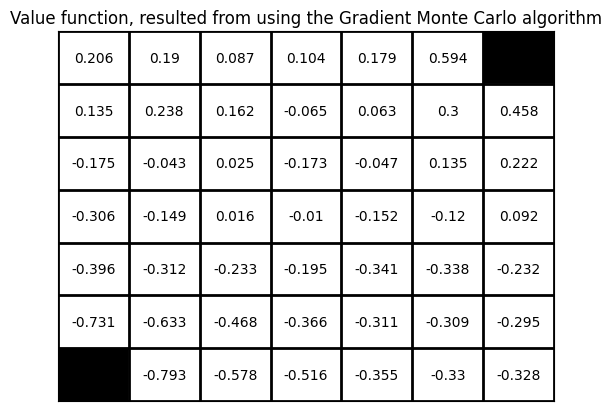

In [25]:
plot_MC,ax_MC = plot(np.round(value_grid_MC, decimals=3))
ax_MC.title.set_text('Value function, resulted from using the Gradient Monte Carlo algorithm')
plt.show()

## Semi-Gradient TD(0) Algorithm

In [26]:
import numpy as np

def affine_feature(state, grid_size):
    x, y = state
    features = np.zeros((grid_size, grid_size))
    features[x, y] = 1

    return features.flatten()

def value_function(features, w):
    return np.dot(w, features)

def gradient(features):
    return features

In [27]:
def take_action(state, action, grid_size):
    x, y = state
    if action == 'up':
        next_state = (max(x - 1, 0), y)
    elif action == 'down':
        next_state = (min(x + 1, grid_size - 1), y)
    elif action == 'left':
        next_state = (x, max(y - 1, 0))
    elif action == 'right':
        next_state = (x, min(y + 1, grid_size - 1))

    if next_state == (grid_size-1, 0):
        return next_state, -1
    elif next_state == (0, grid_size-1):
        return next_state, 1
    else:
        return next_state, 0

def semi_gradient_td0(grid_size, num_episodes, alpha, gamma):
    w = np.zeros((grid_size * grid_size))  # Initialize weights
    start_state = (grid_size // 2, grid_size // 2)

    for episode in range(num_episodes):
        state = start_state

        while state != (grid_size-1, 0) and state != (0, grid_size-1):
            features = affine_feature(state, grid_size)
            action = np.random.choice(['up', 'down', 'left', 'right'])
            next_state, reward = take_action(state, action, grid_size)
            next_features = affine_feature(next_state, grid_size)

            delta = reward + gamma * value_function(next_features, w) - value_function(features, w)
            w += alpha * delta * gradient(features)

            state = next_state

    return w

def compute_value_grid(grid_size, w):
    V = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            features = affine_feature((i, j), grid_size)
            V[i, j] = value_function(features, w)
    return V

# Algorithm execution
grid_size = 7
num_episodes = 20000
alpha = 0.05
gamma = 0.99
weights = semi_gradient_td0(grid_size, num_episodes, alpha, gamma)
value_grid_TD = compute_value_grid(grid_size, weights)
print("Value function, calculated by using semi-gradient TD(0) algorithm:\n", np.round(value_grid_TD, 3))



Value function, calculated by using semi-gradient TD(0) algorithm:
 [[ 0.031  0.053  0.123  0.213  0.376  0.671  0.   ]
 [-0.006  0.014  0.09   0.162  0.273  0.498  0.583]
 [-0.088 -0.038  0.026  0.069  0.187  0.32   0.355]
 [-0.184 -0.131 -0.045  0.009  0.102  0.185  0.203]
 [-0.34  -0.268 -0.13  -0.08   0.026  0.09   0.096]
 [-0.644 -0.384 -0.23  -0.128 -0.056  0.031  0.051]
 [ 0.    -0.458 -0.316 -0.194 -0.089 -0.032  0.002]]


/var/folders/3c/lwpv6l694y7315cz7gxhct1w0000gn/T/ipykernel_1737/1523571044.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 6-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


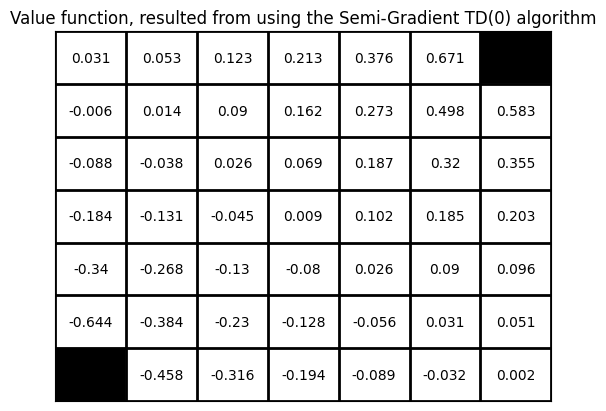

In [28]:
plot_TD,ax_TD = plot(np.round(value_grid_TD, decimals=3))
ax_TD.title.set_text('Value function, resulted from using the Semi-Gradient TD(0) algorithm')
plt.show()

# Exact calculation using Bellman equation

In [29]:
import numpy as np
from scipy.linalg import solve

def value_Bellman(grid_size, gamma):
    """Solving the system of Bellman equations for the gridworld problem."""

    # Define parameters
    num_states = grid_size * grid_size
    actions = ['up', 'down', 'left', 'right']

    # Define special squares
    lower_left = (grid_size - 1, 0)
    upper_right = (0, grid_size - 1)
    start_state = (grid_size // 2, grid_size // 2)

    # Helper function to convert (row, col) to state index
    def state_index(row, col):
        return row * grid_size + col

    # Initialize transition and reward matrices
    P = np.zeros((num_states, num_states, len(actions)))
    R = np.zeros((num_states, len(actions)))

    # Define transition probabilities and rewards
    for row in range(grid_size):
        for col in range(grid_size):
            state = state_index(row, col)
            for action in actions:
                if action == 'up':
                    next_row, next_col = (row - 1, col) if row > 0 else (row, col)
                elif action == 'down':
                    next_row, next_col = (row + 1, col) if row < grid_size - 1 else (row, col)
                elif action == 'left':
                    next_row, next_col = (row, col - 1) if col > 0 else (row, col)
                elif action == 'right':
                    next_row, next_col = (row, col + 1) if col < grid_size - 1 else (row, col)

                next_state = state_index(next_row, next_col)

                if (row, col) == lower_left:                                # Agent at terminal state
                    R[state, actions.index(action)] = 0
                    P[state, state, actions.index(action)] = 1
                    continue
                elif (row, col) == upper_right:                             # Agent at terminal state
                    R[state, actions.index(action)] = 0
                    P[state, state, actions.index(action)] = 1
                    continue
                elif (next_row, next_col) == lower_left:                    # Agent move to lower left terminal state
                    R[state, actions.index(action)] = -1
                    P[state, next_state, actions.index(action)] = 1
                    continue
                elif (next_row, next_col) == upper_right:                   # Agent move to upper right terminal state
                    R[state, actions.index(action)] = 1
                    P[state, next_state, actions.index(action)] = 1
                    continue
                else:
                    R[state, actions.index(action)] = 0
                    P[state, next_state, actions.index(action)] = 1
                    continue

    # Construct the system of Bellman equations
    A = np.eye(num_states)
    b = np.zeros(num_states)

    for state in range(num_states):
        for action in actions:
            action_index = actions.index(action)
            for next_state in range(num_states):
                A[state, next_state] -= gamma * P[state, next_state, action_index] * 0.25
            b[state] += R[state, action_index] * 0.25

    # Solve the linear system A * V = b
    V = solve(A, b)

    # Return the value function reshaped to the grid
    return V.reshape((grid_size, grid_size))

# Example usage
grid_size = 7
gamma = 0.99  # Slight discounting
value_grid_BM = value_Bellman(grid_size, gamma)
print("Exact value function calculated by using Bellman equation:\n", np.round(value_grid_BM, 3))


Exact value function calculated by using Bellman equation:
 [[ 0.     0.031  0.093  0.193  0.344  0.585  0.   ]
 [-0.031  0.     0.06   0.149  0.27   0.423  0.585]
 [-0.093 -0.06   0.     0.08   0.173  0.27   0.344]
 [-0.193 -0.149 -0.08   0.     0.08   0.149  0.193]
 [-0.344 -0.27  -0.173 -0.08   0.     0.06   0.093]
 [-0.585 -0.423 -0.27  -0.149 -0.06   0.     0.031]
 [ 0.    -0.585 -0.344 -0.193 -0.093 -0.031  0.   ]]


/var/folders/3c/lwpv6l694y7315cz7gxhct1w0000gn/T/ipykernel_1737/1523571044.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(patches.Rectangle((j-0.5, 6-i-0.5), 1, 1, fill=True, color=color, edgecolor='black'))


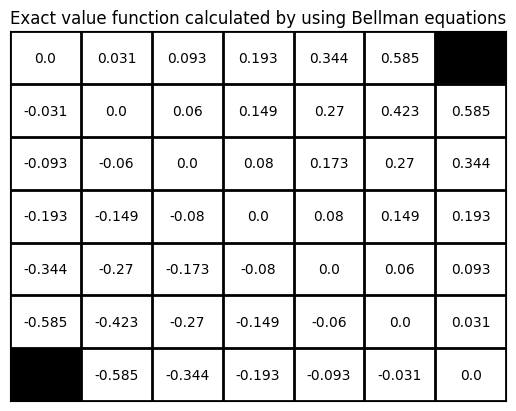

In [30]:
plot_BM,ax_BM = plot(np.round(value_grid_BM, decimals=3))
ax_BM.title.set_text('Exact value function calculated by using Bellman equations')
plt.show()